In [2]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mean_squared_error
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.models import Sequential
import gc
from sklearn.linear_model import LinearRegression

from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [3]:
agg_data1 = pd.read_csv("aggday.csv")


In [4]:
set(agg_data1[agg_data1['kwh']>20]['Source'])

{'consumer_device_10_data_user_10',
 'consumer_device_10_data_user_11',
 'consumer_device_10_data_user_2',
 'consumer_device_10_data_user_6',
 'consumer_device_10_data_user_7',
 'consumer_device_10_data_user_9',
 'consumer_device_12_data_user_4',
 'consumer_device_12_data_user_5',
 'consumer_device_12_data_user_6',
 'consumer_device_13_data_user_1',
 'consumer_device_13_data_user_10',
 'consumer_device_13_data_user_11',
 'consumer_device_13_data_user_12',
 'consumer_device_13_data_user_13',
 'consumer_device_13_data_user_4',
 'consumer_device_13_data_user_5',
 'consumer_device_13_data_user_6',
 'consumer_device_13_data_user_7',
 'consumer_device_13_data_user_8',
 'consumer_device_13_data_user_9',
 'consumer_device_18_data_user_10',
 'consumer_device_18_data_user_11',
 'consumer_device_18_data_user_12',
 'consumer_device_18_data_user_4',
 'consumer_device_18_data_user_5',
 'consumer_device_18_data_user_6',
 'consumer_device_18_data_user_7',
 'consumer_device_18_data_user_8',
 'consumer_

In [5]:
aggregated_data = pd.read_csv("Data/Data.csv")


In [225]:
source_name = 'consumer_device_16_data_user_6' # Remplacer par le nom de la source


In [226]:
df= aggregated_data [aggregated_data ['Source']==source_name]

In [227]:
# Convertir 'date_time' en datetime si ce n'est pas déjà fait
df['date_time'] = pd.to_datetime(df['date_time'])

# Extraire l'heure de la colonne 'date_time'
df['hour'] = df['date_time'].dt.floor('H')  # Arrondir à l'heure la plus proche

# Agréger les données par 'consumer_device', 'data_user' et 'hour' (au lieu de 'Date')
agg_data = df.groupby([ 'hour'])[['kwh']].sum().reset_index()


In [228]:
complete_data=agg_data.copy()

In [229]:
#complete_data=complete_data [complete_data ['Source']==source_name]

In [230]:

complete_data.rename(columns={'hour': 'Date'}, inplace=True)


In [231]:
def climatiseur(complete_data):
    climate_df = pd.read_excel("Climate Data/Kalam Climate Data.xlsx")  # Convert to datetime
    complete_data["Date"] = pd.to_datetime(complete_data["Date"])
    climate_df["Date Time"] = pd.to_datetime(climate_df["Date Time"])

    # Aggregate climate data to hourly level
    climate_hourly = climate_df.groupby(climate_df["Date Time"].dt.floor('H')).agg({
        "Temperature (°C)": "mean",
        "Dewpoint Temperature (°C)": "mean",
        "U Wind Component (m/s)": "mean",
        "V Wind Component (m/s)": "mean",
        "Total Precipitation (mm)": "sum",
        "Snowfall (mm)": "sum",
        "Snow Cover (%)": "mean",
    }).reset_index()

    # Convert 'Date' column in climate_hourly to datetime format
    climate_hourly.rename(columns={"Date Time": "Date"}, inplace=True)
    climate_hourly["Date"] = pd.to_datetime(climate_hourly["Date"])  # Ensure datetime64[ns]

    # Merge with complete_data
    complete_data["Date"] = complete_data["Date"].dt.floor('H')  # Ensure hourly format for merge
    complete_data = complete_data.merge(climate_hourly, on="Date", how="left")
    
    return complete_data


In [232]:
import numpy as np
import pandas as pd

def pro2(complete_data):

    # Assurer que 'Date' est bien en format datetime
    complete_data['Date'] = pd.to_datetime(complete_data['Date'])

    # Extraire jour, mois, année et heure
    complete_data['day'] = complete_data['Date'].dt.day
    complete_data['month'] = complete_data['Date'].dt.month
    complete_data['year'] = complete_data['Date'].dt.year
    complete_data['hour'] = complete_data['Date'].dt.hour

    # Transformation circulaire pour les jours du mois (1 à 31)
    complete_data['day_sin'] = np.sin(2 * np.pi * complete_data['day'] / 31)
    complete_data['day_cos'] = np.cos(2 * np.pi * complete_data['day'] / 31)

    # Transformation circulaire pour les mois (1 à 12)
    complete_data['month_sin'] = np.sin(2 * np.pi * complete_data['month'] / 12)
    complete_data['month_cos'] = np.cos(2 * np.pi * complete_data['month'] / 12)

    # Transformation circulaire pour les années (en fonction de l'année minimale présente)
    year_min = complete_data['year'].min()
    complete_data['year_sin'] = np.sin(
        2 * np.pi * (complete_data['year'] - year_min) 
        / (complete_data['year'].max() - year_min + 1)
    )
    complete_data['year_cos'] = np.cos(
        2 * np.pi * (complete_data['year'] - year_min) 
        / (complete_data['year'].max() - year_min + 1)
    )

    # Transformation circulaire pour l'heure (0 à 23)
    complete_data['hour_sin'] = np.sin(2 * np.pi * complete_data['hour'] / 24)
    complete_data['hour_cos'] = np.cos(2 * np.pi * complete_data['hour'] / 24)

    # Déterminer si c'est un week-end (samedi = 5, dimanche = 6)
    complete_data['is_weekend'] = complete_data['Date'].dt.weekday >= 5

    return complete_data


In [233]:

complete_data=climatiseur(complete_data)


In [234]:
complete_data=pro2(complete_data)


In [235]:
complete_data['Date'] = pd.to_datetime(complete_data['Date'], format='%Y.%m.%d %H:%M:%S')


In [244]:
split_date = pd.to_datetime('2024-7-22')

complete_data=complete_data[complete_data['Date']> split_date]

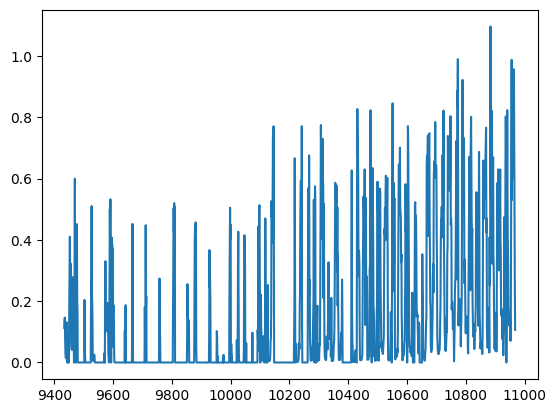

In [245]:
plt.plot(complete_data['kwh'])

In [267]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# 1. Chargement des données
complete_data['Date'] = pd.to_datetime(complete_data['Date'])

# Définir la date de séparation
split_date = pd.to_datetime('2024-09-13')

# Séparer les données en ensembles d'entraînement, de test et de prévision
train_data = complete_data[complete_data['Date'] <= split_date]
test_data = complete_data[(forcast_date >= complete_data['Date']) & (complete_data['Date'] > split_date)]

# Séparer les caractéristiques (X) et la cible (y)
X_train = train_data.drop(columns=['kwh', 'Date'])
y_train = train_data['kwh']

X_test = test_data.drop(columns=['kwh', 'Date'])
y_test = test_data['kwh']


# 2. Encodage des colonnes catégorielles

# Vérification et encodage des colonnes catégorielles
X_train_encoded = X_train
X_test_encoded =X_test

# Aligner les colonnes pour s'assurer qu'elles sont identiques
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)


# 3. Normalisation des caractéristiques et des cibles
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_encoded)
X_test_scaled = scaler_X.transform(X_test_encoded)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape pour GRU (batch_size, time_steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Fonction de planification du taux d'apprentissage
def scheduler(epoch, lr):
    if epoch % 50 == 0 and epoch != 0:
        return lr * 0.5
    return lr

# 4. Construction du modèle GRU
model = Sequential()

model.add(GRU(128, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(GRU(64, activation='relu', return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))




model.add(Dense(1, activation='relu'))

# Compilation
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping et sauvegarde du meilleur modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_gru_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
lr_scheduler = LearningRateScheduler(scheduler)

# Entraînement
history = model.fit(
    X_train_reshaped, y_train_scaled,
    validation_data=(X_test_reshaped, y_test_scaled),
    epochs=300,
    batch_size=16,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Charger le meilleur modèle
model = load_model('best_gru_model.h5')

# Prédictions et dénormalisation
y_pred_scaled = model.predict(X_test_reshaped).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Calcul du RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


Epoch 1/300
80/80 [==============================] - ETA: 0s - loss: 1.1594
Epoch 1: val_loss improved from inf to 0.10854, saving model to best_gru_model.h5
80/80 [==============================] - 10s 19ms/step - loss: 1.1594 - val_loss: 0.1085
Epoch 2/300
78/80 [============================>.] - ETA: 0s - loss: 1.0393
Epoch 2: val_loss did not improve from 0.10854
80/80 [==============================] - 1s 9ms/step - loss: 1.0506 - val_loss: 0.1761
Epoch 3/300
78/80 [============================>.] - ETA: 0s - loss: 1.1508
Epoch 3: val_loss did not improve from 0.10854
80/80 [==============================] - 1s 9ms/step - loss: 1.1438 - val_loss: 0.2426
Epoch 4/300
79/80 [============================>.] - ETA: 0s - loss: 1.1849
Epoch 4: val_loss did not improve from 0.10854
80/80 [==============================] - 1s 8ms/step - loss: 1.1818 - val_loss: 0.3202
Epoch 5/300
78/80 [============================>.] - ETA: 0s - loss: 0.9972
Epoch 5: val_loss did not improve from 0.10854


0.278706304748497


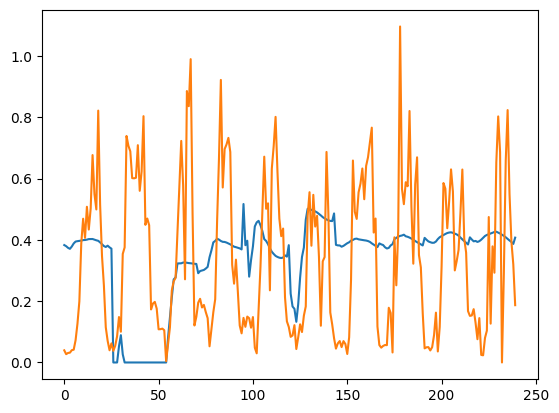

In [268]:
X_test['kwhPred']=y_pred
X_test['kwh']=y_test
name=source_name
l1=list(X_test['kwhPred'])
l2=list(X_test['kwh'] )
rmse = np.sqrt(mean_squared_error(l1,l2))
print(rmse)

plt.plot(l1)
plt.plot(l2)

RMSE journalier (agrégé) : 0.14510949761558295


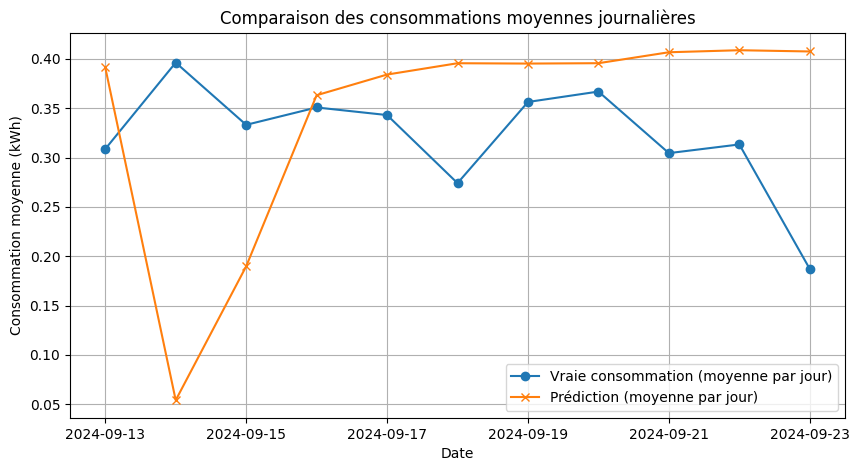

In [273]:
import numpy as np
from sklearn.metrics import mean_squared_error

X_test=test_data.copy()
X_test['kwhPred']=y_pred

# S'assurer que la colonne 'Date' est bien en datetime
X_test['Date'] = pd.to_datetime(X_test['Date'])

# Agréger par jour en prenant la moyenne des valeurs pour 'kwh' et 'kwhPred'
daily_aggregation = X_test.groupby(X_test['Date'].dt.date)[['kwh', 'kwhPred']].mean().reset_index()

# Calcul du RMSE entre les moyennes journalières
rmse_daily = np.sqrt(mean_squared_error(daily_aggregation['kwh'], daily_aggregation['kwhPred']))
print(f"RMSE journalier (agrégé) : {rmse_daily}")

# Visualisation des courbes agrégées par jour
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(daily_aggregation['Date'], daily_aggregation['kwh'], label="Vraie consommation (moyenne par jour)", marker='o')
plt.plot(daily_aggregation['Date'], daily_aggregation['kwhPred'], label="Prédiction (moyenne par jour)", marker='x')
plt.title("Comparaison des consommations moyennes journalières")
plt.xlabel("Date")
plt.ylabel("Consommation moyenne (kWh)")
plt.legend()
plt.grid(True)
plt.show()


In [265]:
X

,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),day,month,year,hour,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,hour_sin,hour_cos,is_weekend
10706,4.800531,3.009256,0.039581,-0.605827,0.000000e+00,0.0,0.0,13,9,2024,1,0.485302,-0.874347,-1.0,-1.836970e-16,1.224647e-16,-1.0,0.258819,0.965926,False
10707,5.740045,3.644769,-0.004517,-0.634386,0.000000e+00,0.0,0.0,13,9,2024,2,0.485302,-0.874347,-1.0,-1.836970e-16,1.224647e-16,-1.0,0.500000,0.866025,False
10708,8.982339,4.278955,-0.089828,-0.474918,0.000000e+00,0.0,0.0,13,9,2024,3,0.485302,-0.874347,-1.0,-1.836970e-16,1.224647e-16,-1.0,0.707107,0.707107,False
10709,11.322336,0.884973,-0.206665,0.187899,0.000000e+00,0.0,0.0,13,9,2024,4,0.485302,-0.874347,-1.0,-1.836970e-16,1.224647e-16,-1.0,0.866025,0.500000,False
10710,12.829019,0.879419,0.053986,0.760733,0.000000e+00,0.0,0.0,13,9,2024,5,0.485302,-0.874347,-1.0,-1.836970e-16,1.224647e-16,-1.0,0.965926,0.258819,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10941,9.609399,2.003458,0.046753,-0.899048,4.350000e-07,0.0,0.0,22,9,2024,20,-0.968077,-0.250653,-1.0,-1.836970e-16,1.224647e-16,-1.0,-0.866025,0.500000,True
10942,9.076349,1.217371,0.035706,-0.938576,4.350000e-07,0.0,0.0,22,9,2024,21,-0.968077,-0.250653,-1.0,-1.836970e-16,1.224647e-16,-1.0,-0.707107,0.707107,True
10943,8.652917,0.386636,0.037079,-0.976413,4.350000e-07,0.0,0.0,22,9,2024,22,-0.968077,-0.250653,-1.0,-1.836970e-16,1.224647e-16,-1.0,-0.500000,0.866025,True
10944,8.324274,-0.433569,0.027527,-0.985641,4.350000e-07,0.0,0.0,22,9,2024,23,-0.968077,-0.250653,-1.0,-1.836970e-16,1.224647e-16,-1.0,-0.258819,0.965926,True
